# Stellar Encounter Collision Model - Tutorial

This notebook demonstrates how to use the stellar encounter collision model to predict outcomes of stellar collisions, tidal captures, and flybys.

Generated with Claude AI

## Table of Contents
1. [Setup and Imports](#setup)
2. [Example 1: Single Encounter](#example1)
3. [Example 2: Batch Processing](#example2)
4. [Example 3: Parameter Space Exploration](#example3)
5. [Example 4: Using the Classifier Directly](#example4)
6. [Example 5: Error Handling](#example5)
7. [Advanced: Analyzing Results](#example6)

## 1. Setup and Imports <a name="setup"></a>

First, import the necessary modules.

In [1]:
from model import process_encounters, EncounterRegimeClassifier
import numpy as np
import matplotlib.pyplot as plt

# Optional: for better plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Example 1: Single Encounter <a name="example1"></a>

Process a single stellar encounter and examine the results.

**Scenario**: Two main sequence stars ($1.0 M_{\odot}$ and $0.8 M_{\odot}$ ) at age 1 Gyr approach with a pericenter of $5.0 R_{\odot}$  and velocity at infinity of 50 km/s.

In [2]:
# Define encounter parameters
results = process_encounters(
    ages=[1.0],            # 1 Gyr old stars
    masses1=[1.0],         # 1 solar mass
    masses2=[0.8],         # 0.8 solar masses
    pericenters=[5.0],     # 5 solar radii pericenter
    velocities_inf=[50.0]  # 50 km/s at infinity
)

# Extract the result
result = results[0]

# Map regime flags to names
regime_names = {-1: 'Collision', -2: 'Tidal Capture', -3: 'Flyby'}

print("=== Encounter Results ===")
print(f"Regime: {regime_names[result['regime_flag']]}")
print(f"Classification: {result['predicted_class']}")
print(f"Mass distribution [M☉]: {result['predicted_values']}")
print(f"Total mass: {sum(result['predicted_values']):.2f} M☉")

=== Encounter Results ===
Regime: Flyby
Classification: 2
Mass distribution [M☉]: [1.0, 0.8, 0.0]
Total mass: 1.80 M☉


## 3. Example 2: Batch Processing Multiple Encounters <a name="example2"></a>

Process multiple encounters simultaneously for efficiency.

**Note**: Models load once on the first call, making subsequent processing much faster.

In [3]:
# Define multiple encounters
ages = [0.5, 1.0, 2.0, 1.0, 0.8]
masses1 = [1.0, 1.2, 0.8, 1.5, 1.1]
masses2 = [0.8, 0.9, 0.6, 1.0, 0.7]
pericenters = [3.0, 5.0, 10.0, 2.0, 15.0]
velocities = [100.0, 50.0, 30.0, 150.0, 40.0]

# Process all encounters
results = process_encounters(ages, masses1, masses2, pericenters, velocities)

# Display results in a formatted table
print("\n=== Batch Processing Results ===")
print(f"{'ID':<4} {'Age':<6} {'M1':<6} {'M2':<6} {'Rp':<6} {'V∞':<8} {'Regime':<15} {'Class':<6}")
print("-" * 75)

for i, result in enumerate(results):
    regime_name = regime_names[result['regime_flag']]
    print(f"{i:<4} {ages[i]:<6.1f} {masses1[i]:<6.1f} {masses2[i]:<6.1f} "
          f"{pericenters[i]:<6.1f} {velocities[i]:<8.1f} {regime_name:<15} {result['predicted_class']:<6}")

# Count regime types
regime_counts = {-1: 0, -2: 0, -3: 0}
for result in results:
    regime_counts[result['regime_flag']] += 1

print(f"\nSummary:")
print(f"  Collisions: {regime_counts[-1]}")
print(f"  Tidal Captures: {regime_counts[-2]}")
print(f"  Flybys: {regime_counts[-3]}")


=== Batch Processing Results ===
ID   Age    M1     M2     Rp     V∞       Regime          Class 
---------------------------------------------------------------------------
0    0.5    1.0    0.8    3.0    100.0    Flyby           2     
1    1.0    1.2    0.9    5.0    50.0     Flyby           2     
2    2.0    0.8    0.6    10.0   30.0     Flyby           2     
3    1.0    1.5    1.0    2.0    150.0    Collision       2     
4    0.8    1.1    0.7    15.0   40.0     Flyby           2     

Summary:
  Collisions: 1
  Tidal Captures: 0
  Flybys: 4


## 4. Example 3: Parameter Space Exploration <a name="example3"></a>

Explore how pericenter distance affects encounter outcomes.

This example demonstrates how to systematically vary one parameter while keeping others constant.

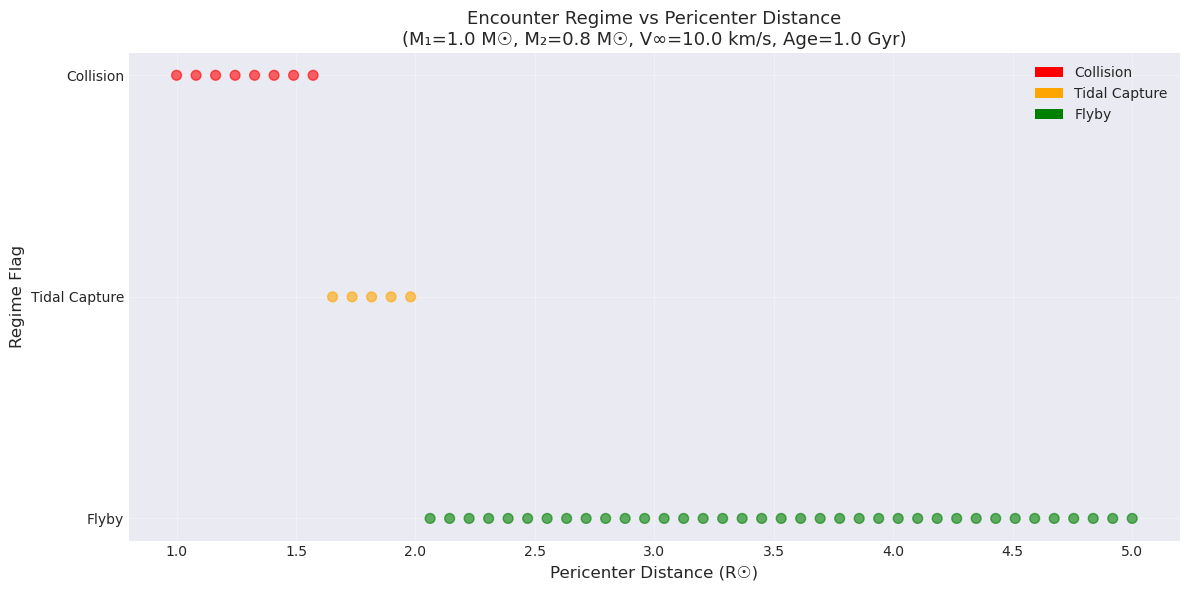

Transition at Rp ≈ 1.65 R☉: Collision → Tidal Capture
Transition at Rp ≈ 2.06 R☉: Tidal Capture → Flyby


In [3]:
# Create a range of pericenter distances
pericenters_range = np.linspace(1.0, 5.0, 50)
n = len(pericenters_range)
# Fixed parameters
fixed_age = 1.0
fixed_mass1 = 1.0
fixed_mass2 = 0.8
fixed_velocity = 10.0

# Process encounters
results = process_encounters(
    ages=[fixed_age] * n,
    masses1=[fixed_mass1] * n,
    masses2=[fixed_mass2] * n,
    pericenters=pericenters_range,
    velocities_inf=[fixed_velocity] * n
)

# Extract regime flags
regimes = [r['regime_flag'] for r in results]

# Plot results
plt.figure(figsize=(12, 6))

# Create color map
colors = {-1: 'red', -2: 'orange', -3: 'green'}
regime_colors = [colors[r] for r in regimes]

plt.scatter(pericenters_range, regimes, c=regime_colors, s=50, alpha=0.6)
plt.xlabel('Pericenter Distance (R☉)', fontsize=12)
plt.ylabel('Regime Flag', fontsize=12)
plt.title(f'Encounter Regime vs Pericenter Distance\n(M₁={fixed_mass1} M☉, M₂={fixed_mass2} M☉, V∞={fixed_velocity} km/s, Age={fixed_age} Gyr)', 
          fontsize=13)
plt.yticks([-1, -2, -3], ['Collision', 'Tidal Capture', 'Flyby'])
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Collision'),
                   Patch(facecolor='orange', label='Tidal Capture'),
                   Patch(facecolor='green', label='Flyby')]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# Find transition points
for i in range(1, len(regimes)):
    if regimes[i] != regimes[i-1]:
        print(f"Transition at Rp ≈ {pericenters_range[i]:.2f} R☉: "
              f"{regime_names[regimes[i-1]]} → {regime_names[regimes[i]]}")

## 5. Example 4: Using the Classifier Directly <a name="example4"></a>

For cases where you only need regime classification without full neural network predictions.

In [8]:
# Initialize classifier
classifier = EncounterRegimeClassifier()

# Classify a single encounter
regime = classifier.classify_encounter(
    age=1.0,
    mass1=1.0,
    mass2=0.8,
    pericenter=5.0,
    velocity_inf=50.0
)

print(f"Encounter type: {regime}")

# Estimate stellar radius for a given age and mass
print("\n=== Stellar Radius Estimation ===")
test_masses = [0.5, 0.8, 1.0, 1.2, 1.5]
test_age = 1.0  # Gyr

for mass in test_masses:
    try:
        radius = classifier.StellarRadiusEstimator(test_age, mass)
        print(f"M = {mass:.1f} M☉ at {test_age} Gyr → R = {radius:.2f} R☉")
    except ValueError as e:
        print(f"M = {mass:.1f} M☉: Error - {e}")

Encounter type: flyby

=== Stellar Radius Estimation ===
M = 0.5 M☉ at 1.0 Gyr → R = 0.43 R☉
M = 0.8 M☉ at 1.0 Gyr → R = 0.73 R☉
M = 1.0 M☉ at 1.0 Gyr → R = 0.90 R☉
M = 1.2 M☉ at 1.0 Gyr → R = 0.97 R☉
M = 1.5 M☉ at 1.0 Gyr → R = 1.13 R☉


## 6. Example 5: Error Handling <a name="example5"></a>

Demonstrate proper error handling for edge cases.

In [6]:
print("=== Testing Error Cases ===")

# Test 1: Post-TAMS star (too old)
print("\n1. Testing post-TAMS star:")
try:
    results = process_encounters(
        ages=[10.0],      # Very old star
        masses1=[1.0],
        masses2=[0.8],
        pericenters=[5.0],
        velocities_inf=[50.0]
    )
    print("  ✓ Success")
except ValueError as e:
    print(f"  ✗ Error (expected): {str(e)[:80]}...")

# Test 2: Mismatched array lengths
print("\n2. Testing mismatched array lengths:")
try:
    results = process_encounters(
        ages=[1.0, 2.0],
        masses1=[1.0],    # Wrong length!
        masses2=[0.8],
        pericenters=[5.0],
        velocities_inf=[50.0]
    )
    print("  ✓ Success")
except ValueError as e:
    print(f"  ✗ Error (expected): {e}")

# Test 3: Valid edge case - very close encounter
print("\n3. Testing very close encounter:")
try:
    results = process_encounters(
        ages=[1.0],
        masses1=[1.0],
        masses2=[0.8],
        pericenters=[0.5],   # Very close
        velocities_inf=[200.0]  # Very fast
    )
    print(f"  ✓ Success: {regime_names[results[0]['regime_flag']]}")
except Exception as e:
    print(f"  ✗ Unexpected error: {e}")

=== Testing Error Cases ===

1. Testing post-TAMS star:
  ✗ Error (expected):  Star of mass 1.0 and age 10.0 Gyr is past the TAMS with a central_h1 fraction o...

2. Testing mismatched array lengths:
  ✗ Error (expected): All input arrays must have the same length

3. Testing very close encounter:
  ✓ Success: Collision
